In [1]:
# Libraries
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import scipy.stats
import datetime

In [3]:
# Load data
financeData = pd.read_csv("HarvardAssets.csv")
interestRates = pd.read_csv("interestrates.csv")

In [4]:
# Populate Real Assets
for i in range(len(financeData)):
    if np.isnan(financeData["realasset"][i]):
        if np.isnan(financeData["natresources"][i]):
            financeData["realasset"][i] = financeData["realest"][i]
        else: 
            financeData["realasset"][i] = financeData["natresources"][i] + financeData["realest"][i]
financeData.head()

,Year,Total Assets,Investment Portfolio,Total Liabilities,Endowment,Total sponsored support,Fed Gov Support – Direct Costs,Salaries/Wages,Scholarships/Student Awards,Endowment Net Change,...,forbond,inflabond,hybond,liqcomm,realest,absreturn,cash,globalequity,realasset,natresources
0,2020-2021,74676115000,61141750000,11301041000,53165753000,926687000,442268000,2076665000,160744000,11271373000,...,1920000,1156229000,275622000,NaN,2.907096e+09,18030872000,1340261000,2.351562e+09,3.371374e+09,4.642780e+08
1,2019-2020,61462439000,48111441000,11292723000,41894380000,917521000,436552000,2131511000,163618000,964680000,...,20729000,935440000,267728000,NaN,3.209643e+09,15515652000,1183983000,1.542236e+09,4.539567e+09,1.329924e+09
2,2018-2019,59327153000,46723970000,10050667000,40929700000,937390000,448832000,2038478000,155874000,1695964000,...,25597000,871832000,237008000,NaN,3.610419e+09,14592876000,1335905000,1.660465e+09,5.524474e+09,1.914055e+09
3,2017-2018,56748281000,45647599000,9784097000,39233736000,914236000,453084000,1943836000,152421000,2137262000,...,25141000,847163000,145132000,NaN,4.005056e+09,12814216000,1407841000,2.008253e+09,6.259865e+09,2.254809e+09
4,2016-2017,53720063000,43275926000,9633984000,37096474000,885535000,452852000,1885692000,147555000,1430731000,...,28378000,825719000,875295000,NaN,5.392029e+09,7964081000,3422154000,1.239346e+09,8.261982e+09,2.869953e+09


In [5]:
# Add numeric years
yearNum = list(map(lambda x : int(x[-4:]), financeData["Year"]))
financeData["YearNum"] = yearNum
temp = []
for i in range(len(interestRates)):
    temp.append(datetime.date(int(interestRates["year"][i]), int(interestRates["month"][i]), int(interestRates["date"][i])))
interestRates["datetime"] = temp
# print(interestRates)

interestRatesAvg = pd.DataFrame()
interestRatesAvg["YearNum"] = np.arange(2003, 2023)
interestRatesAvg["interest"] = np.zeros(20)

for i in range(20):
    temp = interestRates[interestRates["datetime"] >= datetime.date(2003+i, 6, 1)]
    temp = temp.interest[temp["datetime"] <= datetime.date(2004+i, 6, 1)]
    if len(temp) > 0:
        interestRatesAvg["interest"][i] = np.mean(temp)
    else:
        for j in range(len(interestRates)):
            if interestRates["datetime"][j] > datetime.date(2003+i, 6, 1):
                interestRatesAvg["interest"][i] = interestRates["interest"][j-1]
                break
# print(interestRatesAvg)

In [6]:
# Calculating risk and Beta
riskSD = np.std(financeData["Investment Portfolio"])
print(riskSD)
beta = np.cov(financeData["Investment Portfolio"], financeData["sandp"])[0][1]/np.var(financeData["sandp"])
print(beta)

9447234887.293007
6941178.8627791675


In [7]:
# Calculating Delta
financeData["interest"] = np.zeros(18)
for i in range(len(financeData)):
    curr = list(interestRatesAvg["YearNum"]).index(financeData["YearNum"][i])
    financeData["interest"][i] = interestRatesAvg.interest[curr]
print(scipy.stats.pearsonr(financeData["Investment Portfolio"], financeData["interest"]))

(-0.5050340271905869, 0.032537414900120694)


In [8]:
# Investigating which funds stimulate endowment
print(scipy.stats.pearsonr(financeData["Endowment"], financeData["Investment Portfolio"]))
print(scipy.stats.pearsonr(financeData["Endowment"], financeData["Total sponsored support"]))
print(scipy.stats.pearsonr(financeData["Endowment"], financeData["Fed Gov Support – Direct Costs"]))


(0.8295006405702343, 2.071759238757068e-05)
(0.7081952898204555, 0.0010055909060994225)
(0.3030356531943353, 0.22156774952940872)


In [8]:
# Investigating which funds affect Salaries/Wages and Scholarships

In [9]:
# Investigating which investment areas affect portfolio performance
def correlations(dataset):
    print("Start: ")
    print(scipy.stats.pearsonr(dataset["Investment Portfolio"], dataset["dombond"]))
    print(scipy.stats.pearsonr(dataset["Investment Portfolio"], dataset["forbond"]))
    print(scipy.stats.pearsonr(dataset["Investment Portfolio"], dataset["inflabond"]))
    print(scipy.stats.pearsonr(dataset["Investment Portfolio"], dataset["hybond"]))
    print(scipy.stats.pearsonr(dataset["Investment Portfolio"], dataset["realasset"]))
    print(scipy.stats.pearsonr(dataset["Investment Portfolio"], dataset["absreturn"]))
    print(scipy.stats.pearsonr(dataset["Investment Portfolio"], dataset["cash"]))

financeDataSubsetPre = financeData[6:]
financeDataSubsetPost = financeData[:6]

correlations(financeData)
correlations(financeDataSubsetPre)
correlations(financeDataSubsetPost)

# MLR for looking at coefficients
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(financeData[['dombond', 'forbond', 'inflabond', 'hybond', 'realasset', 'absreturn', 'cash']], financeData['Investment Portfolio'])
print(regr.coef_)


Start: 
(0.4162903267077351, 0.08572628065090153)
(0.24013347084828005, 0.33715397348855486)
(-0.1295520687098799, 0.6084051280599383)
(-0.6683369838247917, 0.002430370668242776)
(0.5123489038375123, 0.029711447695117348)
(0.5196823306205506, 0.02707309403433249)
(-0.05441840776248676, 0.8301876955768783)
Start: 
(0.6999551469973134, 0.01126479550837986)
(0.7609786075535894, 0.00404682883266197)
(-0.09102673240409609, 0.7784453524980258)
(-0.6908615421762854, 0.012856685252385014)
(0.7248442265803121, 0.007653775183578668)
(0.7084995396208781, 0.009907023728414193)
(-0.05050892745305645, 0.8761225252899993)
Start: 
(0.21930373216028445, 0.676318012525977)
(0.16348138456209765, 0.7569625382305281)
(0.4337763269028046, 0.39014559895466006)
(-0.35139459479671115, 0.4946028870246886)
(-0.18240519821521073, 0.7294266642116357)
(0.46081581534073257, 0.3577036762822569)
(-0.4747863115526421, 0.3413341825169665)
[-1.14162929  6.80340768  2.16101226 -2.62149487  0.87015903  1.99569894
  0.65414

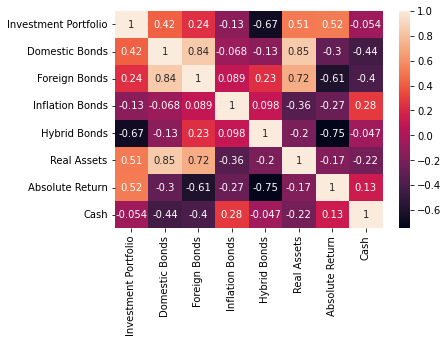

In [11]:
import seaborn as sn
import matplotlib.pyplot as plt
sample_df = pd.DataFrame({'Investment Portfolio': financeData["Investment Portfolio"], 'Domestic Bonds': financeData["dombond"], 'Foreign Bonds': financeData["forbond"], 'Inflation Bonds': financeData["inflabond"], 'Hybrid Bonds': financeData["hybond"], 'Real Assets': financeData["realasset"], 'Absolute Return': financeData["absreturn"], 'Cash': financeData["cash"]})
sample_df.corr()
sn.heatmap(sample_df.corr(), annot=True)
plt.show()

In [9]:
print(financeData.head())

        Year  Total Assets  Investment Portfolio  Total Liabilities  \
0  2020-2021   74676115000           61141750000        11301041000   
1  2019-2020   61462439000           48111441000        11292723000   
2  2018-2019   59327153000           46723970000        10050667000   
3  2017-2018   56748281000           45647599000         9784097000   
4  2016-2017   53720063000           43275926000         9633984000   

     Endowment  Total sponsored support  Fed Gov Support – Direct Costs  \
0  53165753000                926687000                       442268000   
1  41894380000                917521000                       436552000   
2  40929700000                937390000                       448832000   
3  39233736000                914236000                       453084000   
4  37096474000                885535000                       452852000   

   Salaries/Wages  Scholarships/Student Awards  Endowment Net Change  ...  \
0      2076665000                    16074400

In [10]:
# How does portfolio affect student staff benefits
print(scipy.stats.pearsonr(financeData["Endowment"], financeData["Salaries/Wages"]))
print(scipy.stats.pearsonr(financeData["Endowment"], financeData["Scholarships/Student Awards"]))


(0.8239748549503234, 2.6249594205858558e-05)
(0.7970012703470079, 7.498677014469809e-05)


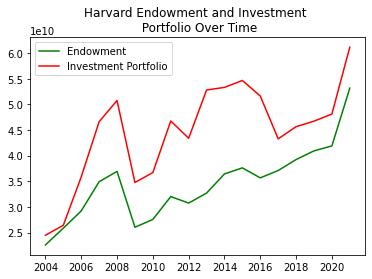

In [11]:
# Visuals for Part A
import matplotlib.pyplot as plt
plt.plot(financeData["YearNum"], financeData["Endowment"], 'g', label='Endowment')
plt.plot(financeData["YearNum"], financeData["Investment Portfolio"], 'r', label='Investment Portfolio')
plt.xticks(np.arange(min(financeData["YearNum"]), max(financeData["YearNum"])+1, 2.0))
plt.title("Harvard Endowment and Investment \n Portfolio Over Time")
plt.legend()
plt.show()

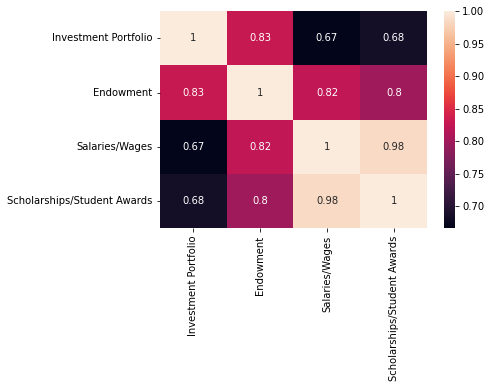

In [12]:
# Visuals for Part A
import seaborn as sn
sample_df = pd.DataFrame({'Investment Portfolio': financeData["Investment Portfolio"], 'Endowment': financeData["Endowment"], 'Salaries/Wages': financeData["Salaries/Wages"], 'Scholarships/Student Awards': financeData["Scholarships/Student Awards"]})
sample_df.corr()
sn.heatmap(sample_df.corr(), annot=True)
plt.show()

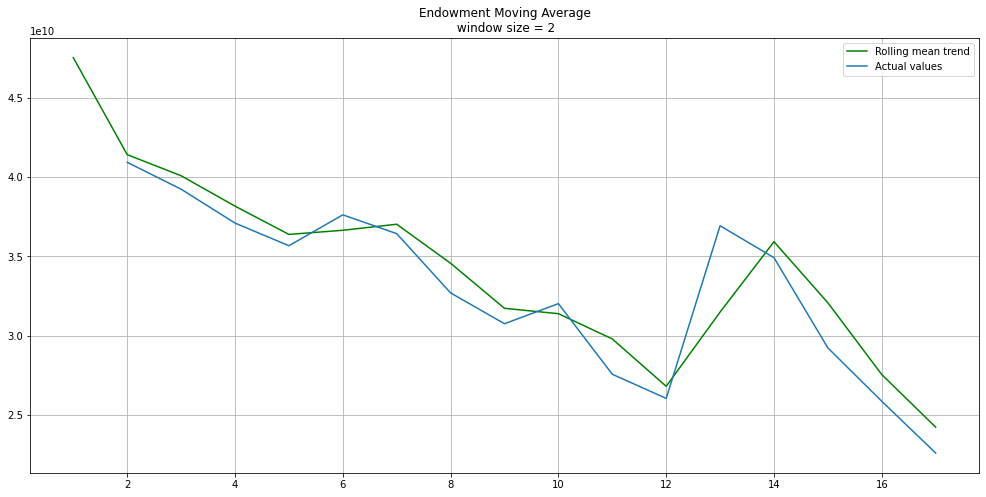

In [16]:
# Simple time series
financeData['YearDate'] = [datetime.datetime(2001, 1, 1) for i in range(len(financeData))]
for i in range(len(financeData)):
    financeData['YearDate'][i] = datetime.datetime(financeData['YearNum'][i], 6, 1)
    
financeData.set_index('YearDate')

def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Endowment Moving Average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    
plot_moving_average(financeData["Endowment"], 2)

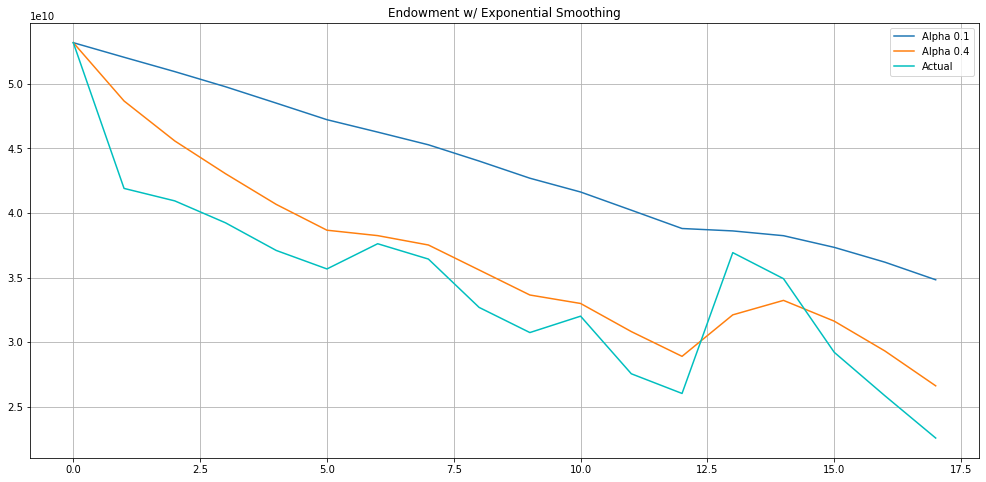

In [19]:
# Exponential smoothing
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Endowment w/ Exponential Smoothing")
    plt.grid(True);
    
plot_exponential_smoothing(financeData["Endowment"], [0.1, 0.4])

/opt/homebrew/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


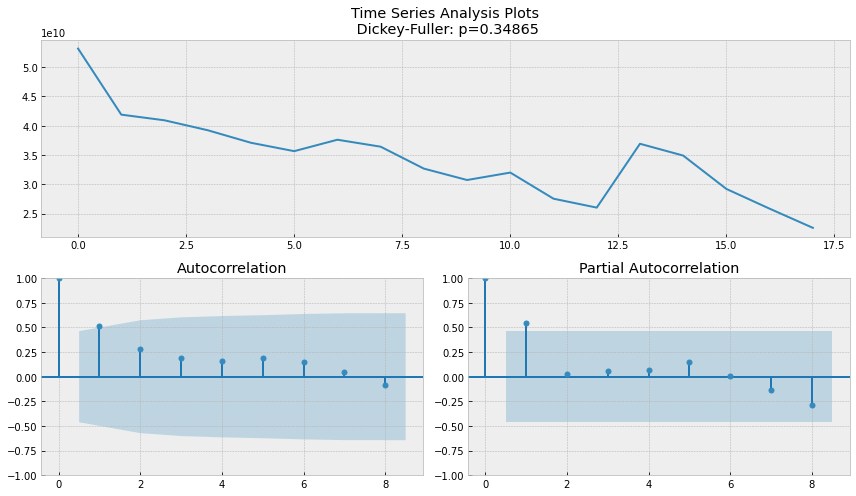

In [15]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm

def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(financeData["Endowment"], lags=8)